In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='password',
    database='db_name'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Jay/OneDrive/Desktop/Python SQL'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

In [2]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
db = mysql.connector.connect(username = 'root',
                            password = 'Mysql@123',
                            host = 'localhost',
                            database = 'ecommerce')

cur = db.cursor()

# 1.List all unique cities where customers are located

In [4]:
query = '''select distinct customer_city from customers'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ['City'])
df.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [5]:
query = '''select count(order_id) from orders where order_purchase_timestamp = 2017'''

cur.execute(query)

data = cur.fetchall()
print(f'The total order purchased in the year 2017 is {data[0][0]}')

The total order purchased in the year 2017 is 45101


# 3. Find the total sales per category.

In [6]:
query = '''select UPPER(products.product_category) category,
        round(sum(payments.payment_value),2)
        from products join order_items
        on products.product_id = order_items.product_id
        join payments on 
        payments.order_id = order_items.order_id
        group by category'''

cur.execute(query)
data = cur.fetchall()
data

[('PERFUMERY', 506738.66),
 ('FURNITURE DECORATION', 1430176.39),
 ('TELEPHONY', 486882.05),
 ('BED TABLE BATH', 1712553.67),
 ('AUTOMOTIVE', 852294.33),
 ('COMPUTER ACCESSORIES', 1585330.45),
 ('HOUSEWARES', 1094758.13),
 ('BABIES', 539845.66),
 ('TOYS', 619037.69),
 ('FURNITURE OFFICE', 646826.49),
 ('COOL STUFF', 779698.0),
 ('HEALTH BEAUTY', 1657373.12),
 ('PET SHOP', 311268.97),
 ('GENERAL INTEREST BOOKS', 64694.76),
 ('STATIONARY STORE', 317440.07),
 ('WATCHES PRESENT', 1429216.68),
 ('PCS', 279121.55),
 ('CLIMATIZATION', 91170.66),
 ('CONSTRUCTION TOOLS CONSTRUCTION', 241475.63),
 ('SPORT LEISURE', 1392127.56),
 ('BAGS ACCESSORIES', 187151.29),
 ('ELECTRONICS', 259857.1),
 ('CASA CONSTRUCAO', 136645.29),
 ('GAMES CONSOLES', 195480.38),
 ('FASHION BAGS AND ACCESSORIES', 218158.28),
 ('HOME APPLIANCES', 95532.27),
 ('GARDEN TOOLS', 838280.75),
 ('AGRO INDUSTRIA E COMERCIO', 118730.61),
 (None, 252801.71),
 ('AUDIO', 60324.62),
 ('TECHNICAL BOOKS', 24915.44),
 ('CONSTRUCTION TOOLS 

In [7]:
df = pd.DataFrame(data , columns = ['Category', 'Sales'])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [8]:
query = """ select ((sum(case when payment_installments >= 1 then 1 else 0 end))/ count(*))*100 from payments"""
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

# 5. Count the number of customers from each state. 

In [9]:
query = """ select count(customer_id) , customer_state state from customers group by state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ['Count','State'])
df.head()

,Count,State
0,41746,SP
1,3637,SC
2,11635,MG
3,5045,PR
4,12852,RJ


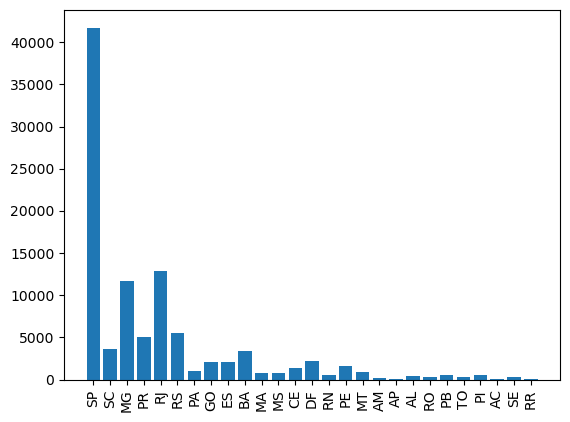

In [10]:
plt.bar( df['State'],df['Count'])
plt.xticks(rotation = 90)
plt.show()

# Intermediate Queries

# 1. Calculate the number of orders per month in 2018.

In [11]:
query = '''select monthname(order_purchase_timestamp) month , count(order_id) order_count
        from orders where year(order_purchase_timestamp) = 2018
        group by month'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Month','No_of_orders'])
o = ['January','February','March','April','May','June','July','August','September','October']
df

,Month,No_of_orders
0,July,6292
1,August,6512
2,February,6728
3,June,6167
4,March,7211
5,January,7269
6,May,6873
7,April,6939
8,September,16
9,October,4


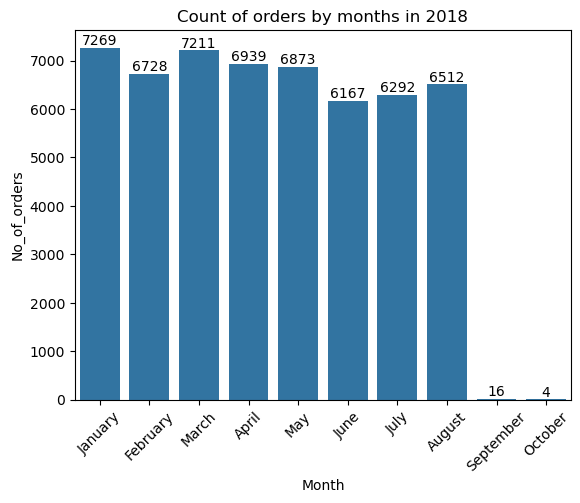

In [12]:
ax = sns.barplot(x = 'Month' , y = 'No_of_orders' , data = df,order = o)
ax.bar_label(ax.containers[0])
plt.xticks(rotation =45)

plt.title('Count of orders by months in 2018')
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [13]:
query = """with count_per_order as(select orders.order_id , orders.customer_id , count(order_items.order_id) as oc
        from orders join order_items
        on orders.order_id = order_items.order_id
        group by orders.order_id , orders.customer_id)

        select customers.customer_city , round(avg(count_per_order.oc)) avg_orders
        from customers join count_per_order
        on customers.customer_id = count_per_order.customer_id
        group by customer_city order by avg_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns = ['City','Avg_order'])
df

,City,Avg_order
0,celso ramos,7
1,padre carvalho,7
2,datas,6
3,candido godoi,6
4,matias olimpio,5
...,...,...
4105,mombaca,1
4106,bom jesus do amparo,1
4107,mucambo,1
4108,oiapoque,1


# 3. Calculate the percentage of total revenue contributed by each product category.

In [14]:
query = '''select (products.product_category) category , sum(payments.payment_value)/(select sum(payment_value) from payments)*100 sales 
        from products join order_items
        on  products.product_id = order_items.product_id
        join payments 
        on payments.order_id = order_items.order_id
        group by category order by sales desc'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category' , 'Percentage'])
df

,Category,Percentage
0,bed table bath,10.697529
1,HEALTH BEAUTY,10.352841
2,computer accessories,9.902824
3,Furniture Decoration,8.933649
4,Watches present,8.927654
...,...,...
69,PC Gamer,0.013583
70,House Comfort 2,0.010685
71,cds music dvds,0.007492
72,Fashion Children's Clothing,0.004908


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [15]:
query ='''select products.product_category , count(order_items.product_id) , round(avg(order_items.price),2)
from products join order_items 
on products.product_id = order_items.product_id
group by products.product_category;'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data ,columns = ['Category','order_count' , 'price'])
df

,Category,order_count,price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14
...,...,...,...
69,flowers,33,33.64
70,Kitchen portable and food coach,15,264.57
71,House Comfort 2,30,25.34
72,CITTE AND UPHACK FURNITURE,38,114.95


In [16]:
array1 =df['order_count']
array2 = df['price']
a = np.corrcoef(array1 , array2)
a

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

In [17]:
print('The correlation between product price and the number of times a product has been purchased is ',a[0][1])

The correlation between product price and the number of times a product has been purchased is  -0.10631514167157562


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [18]:
query = '''select * ,dense_rank() over(order by revenue desc) as rk from 
(select  order_items.seller_id , sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id)as a'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['seller_id','revenue','rank'])
af = df.head(10)

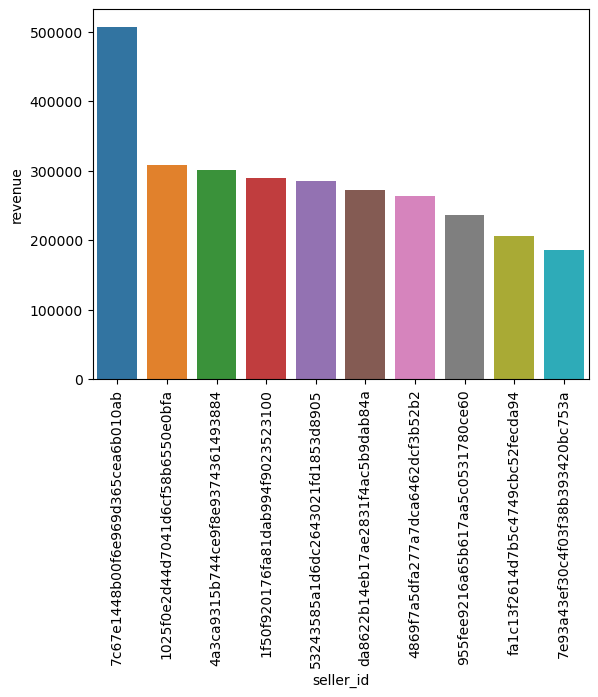

In [19]:
sns.barplot(x = af['seller_id'], y = af['revenue'], hue = af['seller_id'])
plt.xticks(rotation = 90)
plt.show()

# Advanced Queries

# 1. Calculate the moving average of order values for each customer over their order history.

In [20]:
query = '''select customer_id , order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from

(select orders.customer_id , orders.order_purchase_timestamp , 
payments.payment_value as payment
from orders join payments 
on orders.order_id = payments.order_id)as a'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['customer_id', 'timestamp','payment','mov_avg'])
df

,customer_id,timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 2. Calculate the cumulative sales per month for each year.

In [21]:
query = '''select years , months , payment ,sum(payment)
over(order by years , months )  cumulative_sale from
(select year(orders.order_purchase_timestamp) as  years,month(orders.order_purchase_timestamp)as months,
round(sum(payments.payment_value),2) as payment
from orders join payments 
on orders.order_id = payments.order_id
group by years , months order by years , months)as a;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['year','month','payment','cumm_payment'])
df['Date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
df.head()

,year,month,payment,cumm_payment,Date
0,2016,9,252.24,252.24,2016-09-01
1,2016,10,59090.48,59342.72,2016-10-01
2,2016,12,19.62,59362.34,2016-12-01
3,2017,1,138488.04,197850.38,2017-01-01
4,2017,2,291908.01,489758.39,2017-02-01


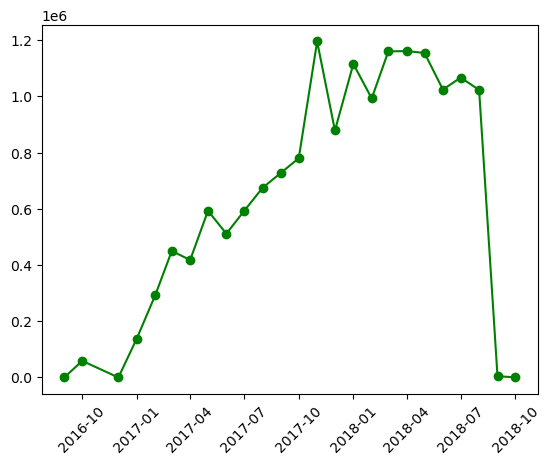

In [22]:
plt.plot(df['Date'],df['payment'], marker='o', label='payment', color='g')
plt.xticks(rotation = 45)
plt.show()

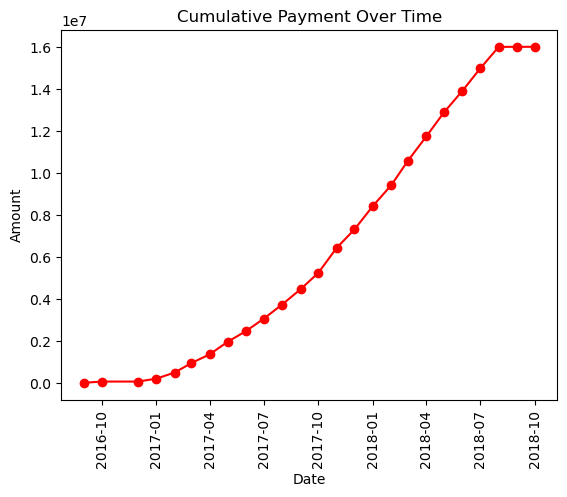

In [23]:
plt.plot(df['Date'], df['cumm_payment'], marker='o', label='Cumulative Payment', color='r')
plt.xticks(rotation = 90)
plt.title('Cumulative Payment Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.show()

# 3. Calculate the year-over-year growth rate of total sales.

In [24]:
query = '''with a as(select year(orders.order_purchase_timestamp) years ,
round(sum(payments.payment_value),2) payment
from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years , ((payment - lag(payment , 1) over(order by years)) / lag(payment , 1) over(order by years))*100
 from a;'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['year','% prev_year_sale'])
df

,year,% prev_year_sale
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


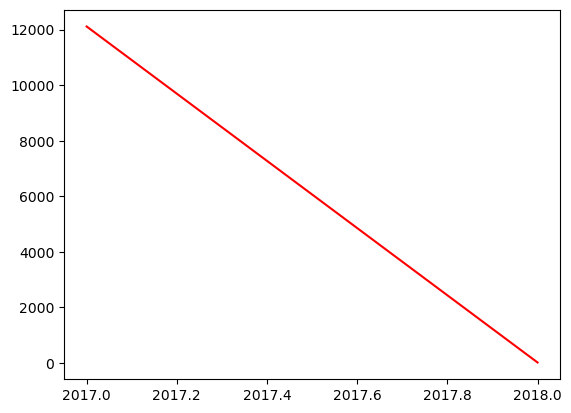

In [25]:
plt.plot(df['year'] , df['% prev_year_sale'] ,color = 'red' )

# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [26]:
# Since none of our customer is repeated hence our value is null
query = '''with a as(select customers.customer_id , min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as(select a.customer_id , count(distinct (orders.order_purchase_timestamp)) next_order
from a join orders
on orders.customer_id =a.customer_id  
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id)) retention
from a left join b
on a.customer_id = b.customer_id;'''

cur.execute(query)
data  = cur.fetchall()
data

[(None,)]

# 5. Identify the top 3 customers who spent the most money in each year.

In [30]:
query = '''select years , total , customer_id ,d_rank 
from
(select year(orders.order_purchase_timestamp) years , sum(payments.payment_value) total, 
orders.customer_id,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) d_rank
from orders join payments
on orders.order_id = payments.order_id
group by orders.customer_id , years ) as a
where d_rank <=3;'''
cur.execute(query)
data  = cur.fetchall()
df = pd.DataFrame(data, columns = ['year','spend','customer_id','rank'])
df

,year,spend,customer_id,rank
0,2016,1423.550049,a9dc96b027d1252bbac0a9b72d837fc6,1
1,2016,1400.739990,1d34ed25963d5aae4cf3d7f3a4cda173,2
2,2016,1227.780029,4a06381959b6670756de02e07b83815f,3
3,2017,13664.080078,1617b1357756262bfa56ab541c47bc16,1
4,2017,6929.310059,c6e2731c5b391845f6800c97401a43a9,2
5,2017,6726.660156,3fd6777bbce08a352fddd04e4a7cc8f6,3
6,2018,7274.879883,ec5b2ba62e574342386871631fafd3fc,1
7,2018,6922.209961,f48d464a0baaea338cb25f816991ab1f,2
8,2018,4809.439941,e0a2412720e9ea4f26c1ac985f6a7358,3


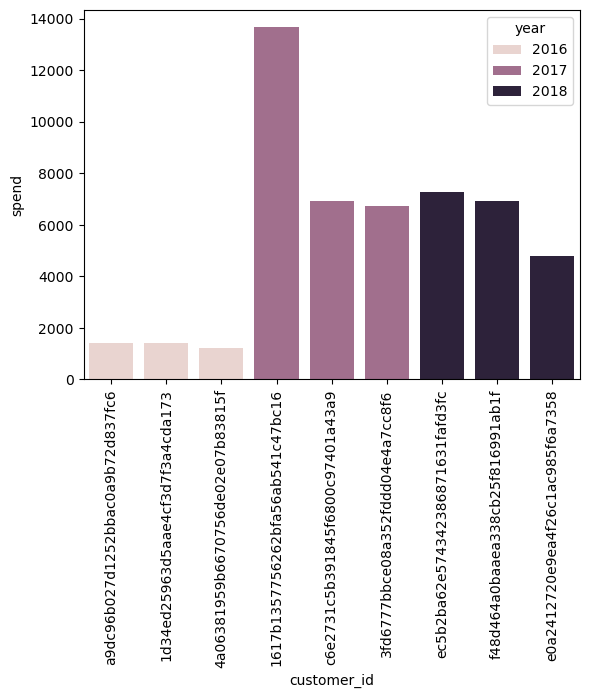

In [34]:
sns.barplot(x = 'customer_id' , y = 'spend', data = df,hue = 'year')
plt.xticks(rotation = 90)
plt.show()